<a href="https://colab.research.google.com/github/kola1037/deep-learning-keras-tf-tutorial/blob/master/Copy_of_intro_to_deep_learning_sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis - Classical Approach VS Deep Learning

![love_scrable.jpg](attachment:love_scrable.jpg)

<span>Photo by <a href="https://unsplash.com/@gaellemarcel?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Gaelle Marcel</a> on <a href="https://unsplash.com/s/photos/computer-text?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>.

# Introduction

This project's aim, is to explore the world of *Natural Language Processing* (NLP) by building what is known as a **Sentiment Analysis Model**. A sentiment analysis model is a model that analyses a given piece of text and predicts whether this piece of text expresses positive or negative sentiment.

![sentiment_classification.png](attachment:sentiment_classification.png)

To this end, we will be using the `sentiment140` dataset containing data collected from twitter. An impressive feature of this dataset is that it is *perfectly* balanced (i.e., the number of examples in each class is equal).

Citing the [creators](http://help.sentiment140.com/for-students/) of this dataset:

> *Our approach was unique because our training data was automatically created, as opposed to having humans manual annotate tweets. In our approach, we assume that any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative. We used the Twitter Search API to collect these tweets by using keyword search*

After a series of **cleaning and data processing**, and after visualizing our data in a **word cloud**, we will be building a **Naive Bayezian** model. This model's goal would be to properly classify positive and negative tweets in terms of sentiment.
Next, we will propose a much more advanced solution using a **deep learning** model: **LSTM**. This process will require a different kind of data cleaning and processing. Also, we will discover **Word Embeddings**, **Dropout** and many other machine learning related concepts.

Throughout this notebook, we will take advantage of every result, visualization and failure in order to try and further understand the data, extract insights and information from it and learn how to improve our model. From the type of words used in positive/negative sentiment tweets, to the vocabulary diversity in each case and the day of the week in which these tweets occur, to the overfitting concept and grasping the huge importance of the data while building a given model, I really hope that you'll enjoy going through this notebook and gain not only technical skills but also analytical skills from it.

---

This notebook is written by **Joseph Assaker**. Feel free to reach out for any feedback on this notebook via [email](mailto:lb.josephassaker@gmail.com) or [LinkedIn](https://www.linkedin.com/in/joseph-assaker/).

---

Now, let's start with the fun 🎉

### **Table of Content:**

 1. [Importing and Discovering the Dataset](#head-1)  
 2. [Cleaning and Processing the Data](#head-2)  
  2.1. [Tokenization](#head-2-1)  
  2.2. [Lemmatization](#head-2-2)  
  2.3. [Cleaning the Data](#head-2-3)  
 3. [Visualizing the Data](#head-3)
 4. [Naive Bayesian Model](#head-4)  
  4.1. [Splitting the Data](#head-4-1)  
  4.2. [Training the Model](#head-4-2)  
  4.3. [Testing the Model](#head-4-3)  
  4.4. [Asserting the Model](#head-4-4)    
 5. [Deep Learning Model - LSTM](#head-5)  
  5.1. [Data Pre-processing](#head-5-1)  
&nbsp;&nbsp;&nbsp;&nbsp;5.1.1. [Word Embeddings](#head-5-1-1)  
&nbsp;&nbsp;&nbsp;&nbsp;5.1.2. [Global Vectors for Word Representation (GloVe)](#head-5-1-2)  
&nbsp;&nbsp;&nbsp;&nbsp;5.1.3. [Data Padding](#head-5-1-3)  
  5.2. [Data Transformation](#head-5-2)  
  5.3. [Building the Model](#head-5-3)  
  5.4. [Training the Model](#head-5-4)  
  5.5. [Investigating Possibilties to Improve the Model](#head-5-5)  
&nbsp;&nbsp;&nbsp;&nbsp;5.5.1. [Regularization - Dropout](#head-5-5-1)  
&nbsp;&nbsp;&nbsp;&nbsp;5.5.2. [Inspecting the Data - Unknown Words](#head-5-5-2)  
  5.6. [Predicting on Custom Data](#head-5-6)  
  5.7. [Inspecting Wrongly Predicted Data](#head-5-7)  
 6. [Bonus Section](#head-6)
 7. [Extra Tip: Pickling !](#head-7)
 8. [Further Work](#head-8)

# 1. Importing and Discovering the Dataset <a class="anchor" id="head-1"></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from time import time
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Reading the dataset with no columns titles and with latin encoding 
df_raw = pd.read_csv('drive/My Drive/GoogleColab_files/NLP/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", header=None)

 # As the data has no column titles, we will add our own
df_raw.columns = ["label", "time", "date", "query", "username", "text"]

# Show the first 5 rows of the dataframe.
# You can specify the number of rows to be shown as follows: df_raw.head(10)
# df_raw  = 1600000 rows × 6 columns

In [ ]:
# Checking the data's output balance
# The label '4' denotes positive sentiment and '0' denotes negative sentiment
df_raw['label'].value_counts()

0    800000
4    800000
Name: label, dtype: int64

In [ ]:
# Ommiting every column except for the text and the label, as we won't need any of the other information
df = df_raw[['label', 'text']]
df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


\*\* *Feel free to skip this step if you're working with a powerful machine, or have lots (and I mean lots) of time to spare* 😅 \*\*  
As our data is huge (1,600,000 rows), working with it on a regular machine is very challenging. For this reason, we will trim our dataframe to $\frac{1}{4} $th of its original size.  
As data output balance is key for a better performing algorithm, we will make sure to maintain the data balance while trimming the dataframe.

In [ ]:
# Separating positive and negative rows
df_pos = df[df['label'] == 4]
df_neg = df[df['label'] == 0]
print(len(df_pos), len(df_neg))

800000 800000


In [ ]:
# Only retaining 1/4th of our data from each output group
# Feel free to alter the dividing factor depending on your workspace
# 1/64 is a good place to start if you're unsure about your machine's power
df_pos = df_pos.iloc[:int(len(df_pos)/4)]
df_neg = df_neg.iloc[:int(len(df_neg)/4)]
print(len(df_pos), len(df_neg))

200000 200000


In [ ]:
# Concatinating both positive and negative groups and storing them back into a single dataframe
df = pd.concat([df_pos, df_neg])
len(df)

400000

# 2. Cleaning and Processing the Data <a class="anchor" id="head-2"></a>

## 2.1. Tokenization <a class="anchor" id="head-2-1"></a>

In order to feed our text data to a classification model, we first need to *tokenize* it.  
**Tokenization** is the process of splitting up a single string of text into a list of individual words, or *tokens*.
<br>

Python has a built in string method: *string.split()*, that splits up any given string into a list based on a splitting character (if not specified, will default to *white space*).
<br>

In this example, we will use the **TweetTokenizer**; a Twitter-aware tokenizer provided by the *nltk* library. In addition to a standard tokenizer, this tokenizer will split the input text based on various criterions that are well suited for the tweets use case.

More info can be found at: https://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.casual.

In [ ]:
start_time = time()

from nltk.tokenize import TweetTokenizer
# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = df['text'].tolist()
Y = df['label'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
    if y == 4:
        data.append((tk.tokenize(x), 1))
    else:
        data.append((tk.tokenize(x), 0))
        
# Printing the CPU time and the first 5 elements of our 'data' list
print('CPU Time:', time() - start_time)
data[:5]

CPU Time: 19.972134828567505


[(['I', 'LOVE', '@Health4UandPets', 'u', 'guys', 'r', 'the', 'best', '!', '!'],
  1),
 (['im',
   'meeting',
   'up',
   'with',
   'one',
   'of',
   'my',
   'besties',
   'tonight',
   '!',
   'Cant',
   'wait',
   '!',
   '!',
   '-',
   'GIRL',
   'TALK',
   '!',
   '!'],
  1),
 (['@DaRealSunisaKim',
   'Thanks',
   'for',
   'the',
   'Twitter',
   'add',
   ',',
   'Sunisa',
   '!',
   'I',
   'got',
   'to',
   'meet',
   'you',
   'once',
   'at',
   'a',
   'HIN',
   'show',
   'here',
   'in',
   'the',
   'DC',
   'area',
   'and',
   'you',
   'were',
   'a',
   'sweetheart',
   '.'],
  1),
 (['Being',
   'sick',
   'can',
   'be',
   'really',
   'cheap',
   'when',
   'it',
   'hurts',
   'too',
   'much',
   'to',
   'eat',
   'real',
   'food',
   'Plus',
   ',',
   'your',
   'friends',
   'make',
   'you',
   'soup'],
  1),
 (['@LovesBrooklyn2', 'he', 'has', 'that', 'effect', 'on', 'everyone'], 1)]

## 2.2. Lemmatization <a class="anchor" id="head-2-2"></a>

According to the Cambridge English Dictionary, **Lemmatization** is the process of reducing the different forms of a word to one single form, for example, reducing "builds", "building", or "built" to the lemma "build". This will greatly help our classifier by treating all variants of a given word as being references to the original lemma word. For example, it will avoid interpreting "running" and "run" as completely different inputs.
<br>

In this example, we will use *nltk*'s **WordNetLemmatizer** to accomplish this task. This lemmatizer however takes as input two arguments: a list of tokens to be lemmatized as well as their corresponding *part of speech*. The most common parts of speech in english are nouns and verbs. In order to extract each token's part of speech, we will utilize *nltk*'s *post_tag* function, that takes an input a list of tokens, and returns a list of tuples, where each tuple is composed of a token and its corresponding position tag. Various position tags can be outputted from the pos_tag function, however the most notable ones are:
* **NNP**: Noun, proper, singular
* **NN**: Noun, common, singular or mass.
* **VBG**: Verb, gerund or present participle.
* **VBN**: Verb, past participle.

A full list of position tags can be found at: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [ ]:
import nltk

In [ ]:
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('averaged_perceptron_tagger')
# Previewing the pos_tag() output
print(pos_tag(data[0][0]))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[('I', 'PRP'), ('LOVE', 'VBP'), ('@Health4UandPets', 'NNS'), ('u', 'JJ'), ('guys', 'NNS'), ('r', 'VBP'), ('the', 'DT'), ('best', 'JJS'), ('!', '.'), ('!', '.')]


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        # First, we will convert the pos_tag output tags to a tag format that the WordNetLemmatizer can interpret
        # In general, if a tag starts with NN, the word is a noun and if it stars with VB, the word is a verb.
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

# Previewing the WordNetLemmatizer() output
print(lemmatize_sentence(data[0][0]))

['I', 'LOVE', '@Health4UandPets', 'u', 'guy', 'r', 'the', 'best', '!', '!']


## 2.3. Cleaning the Data <a class="anchor" id="head-2-3"></a>

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
# If it's your first time ever using nltk, you can download nltk's stopwords using: nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words. Including many minimally present cases would negatively impact the performance. 
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
        return ''
    return token

# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        cleaned_token = cleaned(token.lower())
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if cleaned_token not in string.punctuation and len(cleaned_token) > 2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

# Prevewing the remove_noise() output
print(remove_noise(data[0][0]))

['love', 'guy', 'best']


In [ ]:
start_time = time()

# As the Naive Bayesian classifier accepts inputs in a dict-like structure,
# we have to define a function that transforms our data into the required input structure
def list_to_dict(cleaned_tokens):
    return dict([token, True] for token in cleaned_tokens)

cleaned_tokens_list = []

# Removing noise from all the data
for tokens, label in data:
    cleaned_tokens_list.append((remove_noise(tokens), label))

print('Removed Noise, CPU Time:', time() - start_time)
start_time = time()

final_data = []

# Transforming the data to fit the input structure of the Naive Bayesian classifier
for tokens, label in cleaned_tokens_list:
    final_data.append((list_to_dict(tokens), label))
    
print('Data Prepared for model, CPU Time:', time() - start_time)

# Previewing our final (tokenized, cleaned and lemmatized) data list
final_data[:5]

Removed Noise, CPU Time: 411.7011616230011
Data Prepared for model, CPU Time: 1.0564734935760498


[({'best': True, 'guy': True, 'love': True}, 1),
 ({'besties': True,
   'cant': True,
   'girl': True,
   'meet': True,
   'one': True,
   'talk': True,
   'tonight': True,
   'wait': True},
  1),
 ({'add': True,
   'area': True,
   'get': True,
   'hin': True,
   'meet': True,
   'show': True,
   'sunisa': True,
   'sweetheart': True,
   'thanks': True,
   'twitter': True},
  1),
 ({'cheap': True,
   'eat': True,
   'food': True,
   'friend': True,
   'hurt': True,
   'make': True,
   'much': True,
   'plus': True,
   'real': True,
   'really': True,
   'sick': True,
   'soup': True},
  1),
 ({'effect': True, 'everyone': True}, 1)]

# 3. Visualizing the Data <a class="anchor" id="head-3"></a>

**Word Clouds** are one of the best visualizations for words frequencies in text documents.<br>Essentially, what it does is that it produces an image with frequently-appearing words in the text document, where the most frequent words are showcased with bigger font sizes, and less frequent words with smaller font sizes.

Positive words


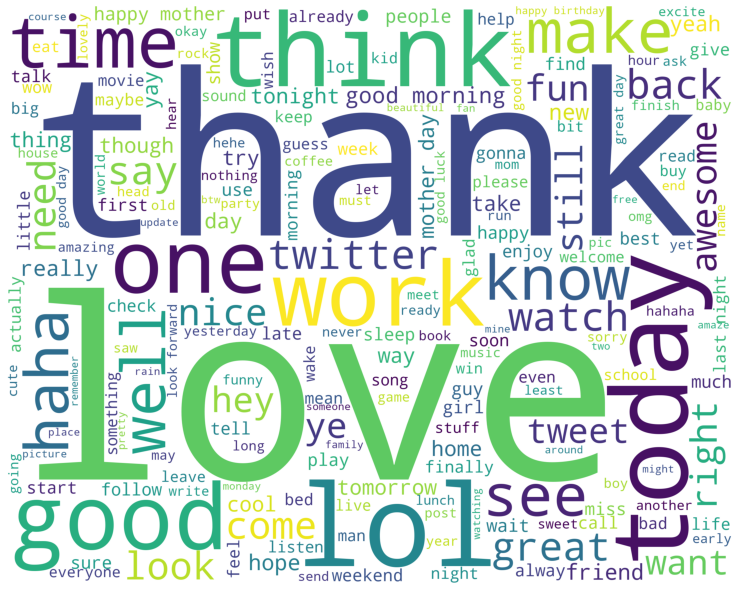

Negative words


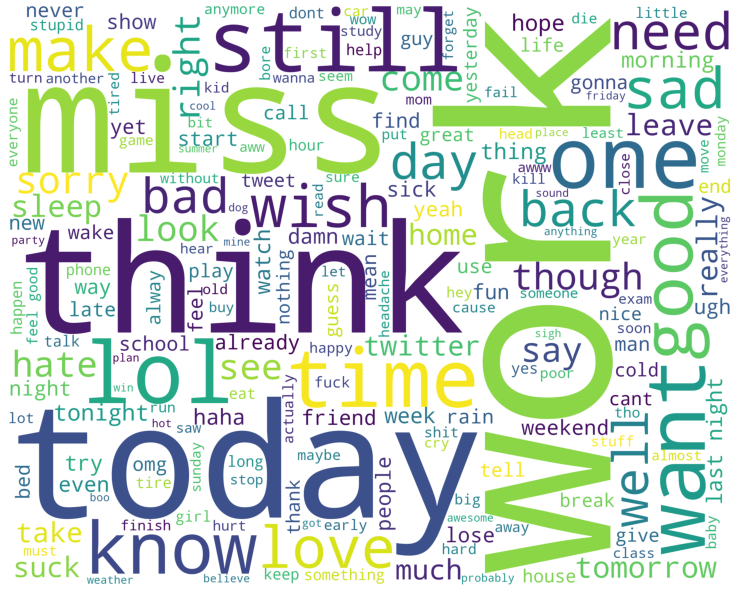

CPU Time: 72.45836520195007


In [ ]:
from wordcloud import WordCloud, STOPWORDS

start_time = time()

positive_words = []
negative_words = []

# Separating out positive and negative words (i.e., words appearing in negative and positive tweets),
# in order to visualize each set of words independently
for i in range(len(cleaned_tokens_list)):
    if cleaned_tokens_list[i][1] == 1:
        positive_words.extend(cleaned_tokens_list[i][0])
    else:
        negative_words.extend(cleaned_tokens_list[i][0])

# Defining our word cloud drawing function
def wordcloud_draw(data, color = 'black'):
    wordcloud = WordCloud(stopwords = STOPWORDS,
                          background_color = color,
                          width = 2500,
                          height = 2000
                         ).generate(' '.join(data))
    plt.figure(1, figsize = (13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive words")
wordcloud_draw(positive_words, 'white')
print("Negative words")
wordcloud_draw(negative_words, 'white')        

print('CPU Time:', time() - start_time)

Those world clouds are beautiful!

It's quite interesting to observe the (higher) occurence of *\"love\"*, *\"lol\"* and *\"thank\"* in the positive tweets, and of *\"work\"* and *\"miss\"* in the negative tweets. However, and in my opinion, the most compelling information observed in those images is without a doubt the huge occurence of the word **today** in the negative tweets.

I personally interpret this information as follows: *Bad news travel faster than good news*. People tend to talk and share bad news much more frequently and much more quickly than good news.

# 4. Naive Bayesian Model <a class="anchor" id="head-4"></a>

Now that our data is *somewhat* clean, we can use it to build our classification model. One of the most commonly used classification models in Natural Language Processing (NLP) is the Naive Bayesian.<br>
**Naive Bayesian** classifiers are a collection of classification algorithms based on Bayes’ Theorem. It is not a single algorithm but rather a family of algorithms where all of them make the following *naive* assumptions:
* All features are independent from each other.
* Every feature contributes equally to the output.

In our case, these two assumptions can be interpreted as:
* Each word is independent from the other words, no relation between any two words of a given sentence.
* Each word contributes equally, throughout all sentences, to the decision of our model, regardless of its relative position in the sentence.

<u>Example:</u> "This is bad" / "This is very bad" or "Such a kind person" / "This kind of chocolate is disgusting", in both cases the Naive Bayesian classifier would give the same importance for the words 'bad' and 'kind', albeit them having a stronger meaning and a different meaning respectively in first and second sentences.

Nevertheless, Naive Bayesian are widely used in NLP and they often output great results.<br>

The **Bayes' Theorem** describes the probability of an event $A$, based on prior knowledge of conditions $B$ that might be related to the event:
$P(A \mid B) = \frac{P(B \mid A)P(A)}{P(B)}$.<br>
In our case, this can be intuitively interpreted as the probability of a tweet being positive, based on prior knowledge of the words inside the input text.
In a nutshell, this probability is: the probability of the first word occuring in a positive tweet, times, the probability of the second word occuring in a positive tweet, ..., times, the probability of a tweet being positive. This can be mathematically written as: $P(A \mid B) \propto P(B_1 \mid A)\times P(B_2 \mid A)  \times  \cdot \cdot \cdot  \times  P(B_n \mid A)\times P(A)$.

More details can be found at: https://www.geeksforgeeks.org/naive-bayes-classifiers/

## 4.1. Splitting the Data <a class="anchor" id="head-4-1"></a>

First, we need to split our data into two sets: Training and Testing sets.<br>
* **Train Data** is data used in order to build and train our classification model.
* **Test Data** is data, that our classifier model has never seen before, used in order to assert the accuracy and test our classification model.

In [ ]:
# As our data is currently ordered by label, we have to shuffle it before splitting it
# .Random(140) randomizes our data with seed = 140. This guarantees the same shuffling for every execution of our code
# Feel free to alter this value or even omit it to have different outputs for each code execution
random.Random(140).shuffle(final_data)

# Here we decided to split our data as 90% train data and 10% test data
# Once again, feel free to alter this number and test the model accuracy
trim_index = int(len(final_data) * 0.9)

train_data = final_data[:trim_index]
test_data = final_data[trim_index:]

## 4.2. Training the Model <a class="anchor" id="head-4-2"></a>

Now it's time to train our model on our training data.
<br>
In this notebook, we will utilize *nltk*'s **NaiveBayesClassifier**.

In [ ]:
start_time = time()

from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

# Output the model accuracy on the train and test data
print('Accuracy on train data:', classify.accuracy(classifier, train_data))
print('Accuracy on test data:', classify.accuracy(classifier, test_data))

# Output the words that provide the most information about the sentiment of a tweet.
# These are words that are heavily present in one sentiment group and very rarely present in the other group.
print(classifier.show_most_informative_features(20))

print('\nCPU Time:', time() - start_time)

Accuracy on train data: 0.8107888888888889
Accuracy on test data: 0.755725
Most Informative Features
               depressed = True                0 : 1      =     49.0 : 1.0
               toothache = True                0 : 1      =     45.0 : 1.0
                    roni = True                0 : 1      =     34.3 : 1.0
                 unhappy = True                0 : 1      =     31.4 : 1.0
                   strep = True                0 : 1      =     31.0 : 1.0
                  asthma = True                0 : 1      =     26.3 : 1.0
                 unloved = True                0 : 1      =     25.0 : 1.0
                  #movie = True                1 : 0      =     23.0 : 1.0
                  gutted = True                0 : 1      =     22.3 : 1.0
                   hates = True                0 : 1      =     21.9 : 1.0
               heartburn = True                0 : 1      =     21.7 : 1.0
                     bom = True                1 : 0      =     21.4 : 1.0

Wow, a 75.5% accuracy on the test set training a very *Naive* (😉) algorithm and in just 36 seconds!

Taking a look at the 20 most informative features of the model, we can notice the high volume of negative to positive (0:1) informative features. This is very interesting as it means that negative tweets have a much more concentrated and limited vocabulary when compared to positive tweets.

I personally interpret this as follows: *Whenever people are in a bad mood, they are confined in such a limited space of words and creativity, in contrast with when they are in a happy mood*.

(Kudos for movies 🎬 for keeping our moods up 😊)

## 4.3. Testing the Model <a class="anchor" id="head-4-3"></a>

Now that our classifier is built, we can have fun and test it with custom tweets!

In [ ]:
custom_tweet = "I ordered just once from TerribleCo, they screwed up, never used the app again."

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

0


In [ ]:
custom_tweet = "I loved the show today! It was amazing."

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

1


In [ ]:
custom_tweet = "No idea"

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

1


Nevertheless, this model has various shortcomings.

As the model only evaluates sentences at an independent word level, it performs very poorly when it comes to negations and other multi-words constructs. For example, is the model gets the following input: **The concert was good!**, it would simply take each individual word (here, and after cleaning the input, *\"concert\"* and *\"good\"*) and calculate each word's probability to be either positive and negative and finally multiply everything together. Thus, we would expect the model to perform poorly on examples such: **The concert was not good!** or **I'm not very happy :(**.

In [ ]:
custom_tweet = "Good"

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

1


In [ ]:
custom_tweet = "Not good"

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

1


Also, the model isn't robust against sarcastic sentences.

In [ ]:
custom_tweet = "The reward for good work is more work!"

custom_tokens = remove_noise(tk.tokenize(custom_tweet))

print(classifier.classify(dict([token, True] for token in custom_tokens)))

1


Finally, it is worth mentioning one more weakness of such a model: it does not generalize well.

The model would perform greatly on data similar to the data it trained on. For example, if the model learned that **I love football** and **I love cooking** carry a positive sentiment, it would be pretty easy for it to classify **I love machine learning** as a sentence carrying a positive sentiment. However, if the model were to classify **I adore embeddings**, it would most probably miss-classify it. As it never encountered any of these words before, therefore it is unable to properly classify it, and would simply output a random choice.

## 4.4. Asserting the Model <a class="anchor" id="head-4-4"></a> 

Finally, let's further assert our model by plotting the AUC and the confusion matrix of the model.

In [ ]:
from sklearn import metrics

# Storing all desired values in a list
y = [test_data[i][1] for i in range(len(test_data))]
# Storing all probabilities of having a positive sentiment in a list
probs = [classifier.prob_classify(test_data[i][0]).prob(1) for i in range(len(test_data))]

# Making sure both values a re equal
print(len(y), len(probs))

# performing the roc curve calculations
fpr, tpr, thresholds = metrics.roc_curve(y, probs)

# Printing the Area Under Curve (AUC) of the ROC curve (the closer to 1, the better)
auc = metrics.roc_auc_score(y, probs)
print('AUC: %.3f' % auc)

40000 40000
AUC: 0.834


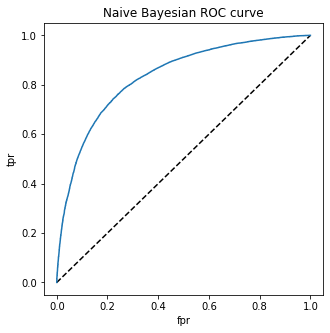

In [ ]:
# Plotting the ROC Curve
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='NB')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Naive Bayesian ROC curve')
plt.show()

In [ ]:
# Creating a confusion matrix (this specific confusion matrix function accepts numpy arrays rather than python lists)

probs = [classifier.classify(test_data[i][0]) for i in range(len(test_data))]
y = np.asarray(y)
probs = np.asarray(probs)
pd.crosstab(y, probs, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,16528,3452,19980
1,6319,13701,20020
All,22847,17153,40000


# 5. Deep Learning Model - LSTM <a class="anchor" id="head-5"></a>

**Deep Learning** is a very rapidly growing field, that is proving to be extremely beneficial in various scenarios. One of those scenarios, which we will be studying in this notebook, is the ability to process text data in a much more complex and powerful manner. In fact, in the next section of the notebook we will be focusing on implementing a Deep Learning model that will successfully tackle and solve the above mentioned shortcomings of the Naive Bayes model, such as the lack of relationship between words in a sentence and the poor generalization on previously unseen data.

---

A **L**ong **S**hort-**T**erm **M**emory, or **LSTM**, is a type of machine learning neural networks. More specifically, it belongs to the family of **R**ecurrent **N**eural **N**etwords (**RNN**) in Deep Learning, which are specifically conceived in order to process *temporal data*. Temporal data is defined as data that is highly influenced by the order that it is presented in. This means that data coming before or after a given datum (singular for *data*) can greatly affect this datum. Text data is an example of temporal data. For example, let's consider the following sentence:

>*Jane is not very happy. She's still mad at you!*

In the above sentence, the word *not* greatly influences the meaning of the upcoming words *very happy*. Also, we used the word *she* as we are speaking about a female subject.

Also, here's a fun example conveying the influence of words' positions directly influencing a sentence's meaning:

>*Are you as clever as I am?*
>
>*Am I as clever as you are?*

------------

LSTM is an advanced and complex deep learning architecture, so we will avoid explaining it in detail in this notebook as it will result in a huge notebook! (Maybe it's a project for the future? 😉)

That being said, you don't really need to know the ins and outs of LSTM in order to walk through the rest of this notebook, so don't worry about it for the moment!

## 5.1. Data Pre-processing <a class="anchor" id="head-5-1"></a>

In order to feed our text data to our LSTM model, we'll have to go through several extra preprocessing steps.

Most neural networks expect *numbers* as inputs. Thus, we'll have to convert our *text* data to *numerical* data.

One way of doing so would be the following: collect all possible words in our dataset and generate a *dictionary* containing all unique words in our text corpus, then sort all of these words alphabetically and assign to each word an *index*. So for example, let's say our dictionary's length turned out to be 100,000 words. The word "a" would be assigned the index 0, the word "aaron" would be assigned the index 1, and so on, until we reach the last word in our dictionary, say "zulu", and assign to it the index 99,999. Great! Now each word is represented with a numerical value, and we can feed the numerical value of each word to our model.

It turns out that this step alone is not enough to be able to train good Deep Learning models. If you think about it, when the model reads an input 20,560 and then another input 20,561 for example, it would assume that these values are "close". However, those inputs could be the indexes of totally unrelated words, such as "cocktail" and "code", appearing right next to each  other in the sorted dictionary. Hoping I've convinced you with this example, and that you hopefully believe that "cocktail" and "code" are, and should always be, completely unrelated, let's take a look at one solution that is widely adopted in various NLP implementations.

----------

*Also, one simple solution for this problem is to use [One-Hot](https://en.wikipedia.org/wiki/One-hot#:~:text=In%20natural%20language%20processing%2C%20a,uniquely%20to%20identify%20the%20word.) vectors to represent each word, but we won't bother with One-Hot vectors in this notebook, as we will be discussing a much more robust solution.*

### 5.1.1. Word Embeddings <a class="anchor" id="head-5-1-1"></a>

Word embeddings are basically a way for us to convert words to *representational vectors*. What I mean by this is that, instead of mapping each word to an index, we want to map each word to a vector of real numbers, representing this word.

The goal here is to be able to generate similar or close representational vectors for words that have similar meaning. For example, when feeding the words "excited" and "thrilled" to the word embedding model, we would like the model to output "close" representations for both words. Whereas if we feed the words "excited" and "Java", we would like the model to output "far" representations for both words.

> The concept of "close" and "far" vectors is actually implemented using the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). In fact, word embeddings and distance between words or relation between words is an immense discussion in its own. So I'll just keep my explanation to a minimum in this notebook.

----------

[This](https://papers.nips.cc/paper/2016/file/a486cd07e4ac3d270571622f4f316ec5-Paper.pdf) is a very interesting paper to read for advanced readers on the subject of word embeddings.

### 5.1.2. Global Vectors for Word Representation (GloVe) <a class="anchor" id="head-5-1-2"></a>

Building and training good word embeddings is a tremendous process requiring millions of data samples and exceptional computational power. Luckily for us, folks at the University of Stanford already did this for us and published their results for free on their official [website](https://nlp.stanford.edu/projects/glove/)! Their model is called **GloVe**, and it's going to be what we'll use in the next steps

In [ ]:
# Downloading and unzipping the glove word embeddings from the official website

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-05-03 23:41:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-03 23:41:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-03 23:41:40--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# Defining a handy function in order to load a given glove file

def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

GloVe embeddings come in various flavors. They basically differ depending on the type of data they were trained on, the length of the vocabulary, the size of the representational vectors and so on.

We've previously downloaded GloVe vectors trained on 6 Billion tokens and having a dictionary, or *vocabulary*, size of 400,001 unique words. Believe it or not, this is the smallest model from GloVe! Next we will load the vectors that are 50-dimensional.

In [ ]:
# Loading the 50-dimensional GloVe embeddings
# This method will return three dictionaries:
# * word_to_index: a dictionary mapping from words to their indices in the vocabulary
# * index_to_word: dictionary mapping from indices to their corresponding words in the vocabulary
# * word_to_vec_map: dictionary mapping words to their GloVe vector representation
# Note that there are 400,001 words, with the valid indices ranging from 0 to 400,000

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [ ]:
word_to_index['hello']

176468

In [ ]:
word_to_vec_map['hello']

array([-0.38497 ,  0.80092 ,  0.064106, -0.28355 , -0.026759, -0.34532 ,
       -0.64253 , -0.11729 , -0.33257 ,  0.55243 , -0.087813,  0.9035  ,
        0.47102 ,  0.56657 ,  0.6985  , -0.35229 , -0.86542 ,  0.90573 ,
        0.03576 , -0.071705, -0.12327 ,  0.54923 ,  0.47005 ,  0.35572 ,
        1.2611  , -0.67581 , -0.94983 ,  0.68666 ,  0.3871  , -1.3492  ,
        0.63512 ,  0.46416 , -0.48814 ,  0.83827 , -0.9246  , -0.33722 ,
        0.53741 , -1.0616  , -0.081403, -0.67111 ,  0.30923 , -0.3923  ,
       -0.55002 , -0.68827 ,  0.58049 , -0.11626 ,  0.013139, -0.57654 ,
        0.048833,  0.67204 ])

As this word embedding only considers 400,000 unique words, it might encounter words it has never seen before. For example, the word "LSTM" is most likely not included in those 400,000 words.

In order to overcome such scenarios, word embeddings reserve an extra spot for "unknown" words, also denoted with the keyword **unk**.

In [ ]:
word_to_index['unk']

372306

Below is a short example of the usage of the cosine similarity in order to find correlations in the data.

We can observe that the words *cucumber* and *tomato* are highly positively similar. Whereas the words *cucumber* and *phone* are not related at all, having a close to 0 similarity measure.

> Note that the cosine similarity return values between -1 and +1, where **-1** denote completely opposite meanings, **+1** denote completely identical meanings and **0** denote totally unrelated meanings.

In [ ]:
def cosine_similarity(u, v):
    dot = np.dot(u, v)
    norm_u = np.sqrt(np.sum(u**2))
    norm_v = np.sqrt(np.sum(v**2))
    cosine_similarity = dot / (norm_u * norm_v)
    return cosine_similarity

In [ ]:
cosine_similarity(word_to_vec_map['cucumber'], word_to_vec_map['tomato'])

0.8632714714841137

In [ ]:
cosine_similarity(word_to_vec_map['cucumber'], word_to_vec_map['phone'])

-0.012485506721235957

### 5.1.3. Data Padding  <a class="anchor" id="head-5-1-3"></a>

Further in our training we would like to speed the process up by splitting data into *mini-batches*. Batch learning is basically the process of training on several examples at the same time, which greatly decreases the training time!

However, and in order to be able to utilize batch learning, keras (and similarly to most machine learning frameworks) requires all data within the same batch to have the same length or *dimension*. Whereas in our text data, each example could have a variable sentence length. In order to overcome this issue, we will go over all of our data, and calculate the length of the longest phrase (in terms of words). Then, we will 0-pad all of the data sequences so that they will all have the same *max_len* calculated.

Let's consider a *max_len* of 5 words, and the two sentences *I love you* and *I will be ready*.
First, we will convert these sentences to their corresponding index representation, then 0-pad them for the *max_len* 5. After we've done that, we can now feed the resulting lists into a word embedding layer in order to get the representational vectors for each index (representing a given word).

![embedding_small.png](attachment:embedding_small.png)

----------------

The image above, as well as various helper functions written in this section are inspired from Coursera's [Sequence Models Course](https://www.coursera.org/learn/nlp-sequence-models) in the [Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning) by [deeplearning.ai](deeplearning.ai).

In the next cell we will write some code in order to perform the above-described process, with the exception of passing the lists to the embedding layer, as this step will be handled by the model.

Note that the first step in this process is similar to the process previously performed for the Naive Bayes model.

## 5.2. Data Transformation <a class="anchor" id="head-5-2"></a>

In [ ]:
start_time = time()

unks = []
UNKS = []

# This function will act as a "last resort" in order to try and find the word
# in the words embedding layer. It will basically eliminate contiguously occuring
# instances of a similar character
def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res


def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i, j] = index

        
# Here we will utilize the already computed 'cleaned_tokens_list' variable
   
print('Removed Noise, CPU Time:', time() - start_time)
start_time = time()

list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

X = np.zeros((len(cleaned_tokens_list), max_len))
Y = np.zeros((len(cleaned_tokens_list), ))

for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label
    
print('Data Prepared for model, CPU Time:', time() - start_time)


print(X[:5])
print(Y[:5])

Removed Noise, CPU Time: 0.00046706199645996094
max_len: 25
Data Prepared for model, CPU Time: 2.596407890319824
[[226278. 169725.  74390.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [239785. 269953. 372306. 361859.  91041. 382320. 161844. 352214.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [357161. 368306.  46173. 372306. 160418. 239785. 179025. 329974.  58999.
  349437.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [330826. 302352.  97698. 184322. 251645. 132701. 302292. 151204. 286963.
  154049. 231458. 338210.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [133896. 141948.      0.      0.      0.      0.      0.  

## 5.3. Building the Model <a class="anchor" id="head-5-3"></a>

In [ ]:
import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split

In [ ]:
# Defining a function that will initialize and populate our embedding layer

def pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["unk"].shape[0] #50
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False, input_shape=(max_len,))
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [ ]:
# Defining a sequencial model composed of firstly the embedding layer, than a pair of Bidirectional LSTMs,
# that finally feed into a sigmoid layer that generates our desired output betwene 0 and 1.

model = Sequential()

model.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 50)            20000050  
                                                                 
 bidirectional (Bidirectiona  (None, 25, 256)          183296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 20,577,843
Trainable params: 577,793
Non-trainable params: 20,000,050
_________________________________________________________________


In [ ]:
# Compiling our model with a binary cross-entropy loss function, using the default adam optimizer
# and setting the accurary as the metric to track and ameliorate

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [ ]:
len(X_train)

320000

In [ ]:
len(X_test)

80000

## 5.4. Training the Model <a class="anchor" id="head-5-4"></a>

In [ ]:
# Setting a batch size of 20 and training our model for 20 epochs

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

Epoch 1/20
2500/2500 [==============================] - 131s 48ms/step - loss: 0.5511 - accuracy: 0.7134 - val_loss: 0.5149 - val_accuracy: 0.7414
Epoch 2/20
2500/2500 [==============================] - 94s 37ms/step - loss: 0.5071 - accuracy: 0.7470 - val_loss: 0.4989 - val_accuracy: 0.7529
Epoch 3/20
2500/2500 [==============================] - 116s 47ms/step - loss: 0.4861 - accuracy: 0.7607 - val_loss: 0.4861 - val_accuracy: 0.7622
Epoch 4/20
2500/2500 [==============================] - 116s 46ms/step - loss: 0.4684 - accuracy: 0.7721 - val_loss: 0.4830 - val_accuracy: 0.7660
Epoch 5/20
2500/2500 [==============================] - 117s 47ms/step - loss: 0.4494 - accuracy: 0.7837 - val_loss: 0.4822 - val_accuracy: 0.7671
Epoch 6/20
2500/2500 [==============================] - 112s 45ms/step - loss: 0.4280 - accuracy: 0.7959 - val_loss: 0.4864 - val_accuracy: 0.7650
Epoch 7/20
2500/2500 [==============================] - 88s 35ms/step - loss: 0.4027 - accuracy: 0.8108 - val_loss: 0.5

In [ ]:
  # Defnining a handy function in order to plot various models accuracy and loss progress

def plot_acc_loss(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

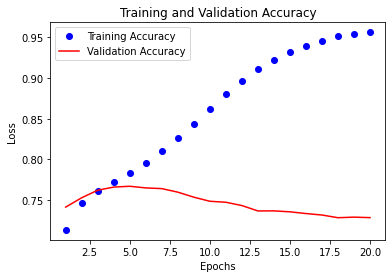

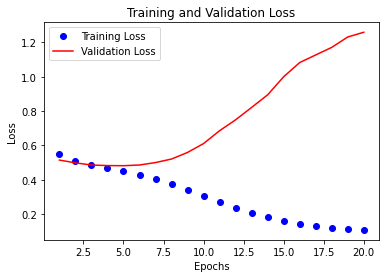

In [ ]:
# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)

The training accuracy is sky-rocketing, exceeding **95%** after 20 epochs! However, the validation accuracy increased slightly in the early epochs, reaching **76.7%** on the 5th epoch, after which it experienced a consistently gradual decrease. In data science, we would classify this model as having very high variance and low bias. This is also referred to as "over-fitting".

**Over-Fitting** is basically the phenomenon where the model's performance on validation data starts degrading, while still achieving great progress on the test set. In other words, the model is doing exceptionally well on learning specific examples it has been trained on, but is failing to generalize to data it never saw in its training phase. 

## 5.5. Investigating Possibilties to Improve the Model <a class="anchor" id="head-5-5"></a>

Several directions could be undertaken at this stage in order to improve our model's performance. Arguably, the most promising direction to firstly look into is to introduce some kind of regularization in our model in order to try to reduce the clearly apparent over-fitting problem our model is facing. Let's specifically  look at the *dropout* regularization technique.

### 5.5.1. Regularization - Dropout <a class="anchor" id="head-5-5-1"></a>

**Regularization** is the process of preventing a model from over-fitting the training data. You can conceptualize regularization as being a tool we use in order to render our model less sensible to every detail, and possibly outliers, in the training data. This should allow the model to better generalize and have a better performance on the validation data, or any data it wasn't trained on.

**Dropout** is one of the many regularization techniques, and also one of the simplest to implement and most commonly used. Basically, what dropout does is that it randomly eliminates several (based on a parametrized percentage rate) neurons connections in the network, rendering the model less complex, and forcing the model to only look at part of a given example. The random elimination of connections in the model is repeated randomly for each example training data.


![dropout.png](attachment:dropout.png)
<center><i>Srivastava, Nitish, et al. ”Dropout: a simple way to prevent neural networks from overfitting”, JMLR 2014</i></center>

<br/>

For example, let's consider the following sentences, with a dropout layer with a rate of 0.5 (50% of connections will be eliminated): 

> "Another kind of regularization can be directly applied to the cost function"
>
> "This is my first ever notebook. Hope you're enjoying it so far!"

The output of the dropout layer could look like the following:

> "kind of regularization be to function"
>
> "This my notebook. you enjoying it far!"

Thus, the model will only have information on a part of the input example, and should be able to escape over-fitting particular characteristics of the training data.

### Model Building - Dropout

In [ ]:
keras.backend.clear_session()

model_dropout = Sequential()

model_dropout.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_dropout.add(Dense(units=1, activation='sigmoid'))

model_dropout.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 50)            20000050  
                                                                 
 dropout (Dropout)           (None, 25, 50)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 25, 256)          183296    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 25, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2

In [ ]:
model_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Model Training - Dropout

In [ ]:
model_dropout.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

Epoch 1/20
2500/2500 [==============================] - 126s 48ms/step - loss: 0.5961 - accuracy: 0.6738 - val_loss: 0.5391 - val_accuracy: 0.7256
Epoch 2/20
2500/2500 [==============================] - 112s 45ms/step - loss: 0.5632 - accuracy: 0.7027 - val_loss: 0.5211 - val_accuracy: 0.7398
Epoch 3/20
2500/2500 [==============================] - 88s 35ms/step - loss: 0.5497 - accuracy: 0.7137 - val_loss: 0.5123 - val_accuracy: 0.7454
Epoch 4/20
2500/2500 [==============================] - 88s 35ms/step - loss: 0.5400 - accuracy: 0.7216 - val_loss: 0.5041 - val_accuracy: 0.7487
Epoch 5/20
2500/2500 [==============================] - 92s 37ms/step - loss: 0.5328 - accuracy: 0.7269 - val_loss: 0.4993 - val_accuracy: 0.7520
Epoch 6/20
2500/2500 [==============================] - 111s 45ms/step - loss: 0.5266 - accuracy: 0.7313 - val_loss: 0.4935 - val_accuracy: 0.7549
Epoch 7/20
2500/2500 [==============================] - 90s 36ms/step - loss: 0.5227 - accuracy: 0.7341 - val_loss: 0.491

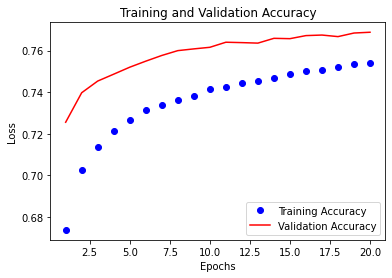

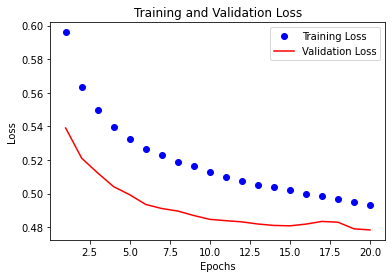

In [ ]:
plot_acc_loss(model_dropout.history)

We can clearly see the effects of adding dropout layers on the training progress. The training accuracy is progressing at a much slower pace than it previously did. Nevertheless, the validation accuracy is steadily increasing, reaching 76.85%.

Let's keep on training the model for 20 more epochs.

In [ ]:
model_dropout.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

Epoch 1/20
2500/2500 [==============================] - 91s 36ms/step - loss: 0.4936 - accuracy: 0.7545 - val_loss: 0.4809 - val_accuracy: 0.7688
Epoch 2/20
2500/2500 [==============================] - 92s 37ms/step - loss: 0.4916 - accuracy: 0.7555 - val_loss: 0.4789 - val_accuracy: 0.7691
Epoch 3/20
2500/2500 [==============================] - 118s 47ms/step - loss: 0.4899 - accuracy: 0.7568 - val_loss: 0.4786 - val_accuracy: 0.7686
Epoch 4/20
2500/2500 [==============================] - 114s 46ms/step - loss: 0.4904 - accuracy: 0.7569 - val_loss: 0.4799 - val_accuracy: 0.7671
Epoch 5/20
2500/2500 [==============================] - 89s 36ms/step - loss: 0.4879 - accuracy: 0.7576 - val_loss: 0.4794 - val_accuracy: 0.7691
Epoch 6/20
2500/2500 [==============================] - 89s 35ms/step - loss: 0.4878 - accuracy: 0.7584 - val_loss: 0.4797 - val_accuracy: 0.7702
Epoch 7/20
2500/2500 [==============================] - 92s 37ms/step - loss: 0.4871 - accuracy: 0.7591 - val_loss: 0.4784

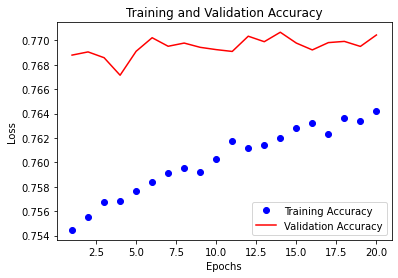

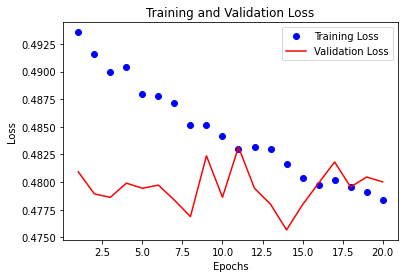

In [ ]:
plot_acc_loss(model_dropout.history)

We can observe that the accuracy has plateaued, reaching its best validation value of **77.2%**.

Thus, we can conclude that the regularization process did not really help us in our case. A tiny **0.5%** improvement was observed after adding dropout to the model.

This leads us to the second direction to investigate in order to improve our model: **data**.

### 5.5.2. Inspecting the Data - Unknown Words <a class="anchor" id="head-5-5-2"></a>

As explained earlier, whenever a word is not included in the words embedding mapping, it is referred to as an unknown word, or *unk*. Let's count the number of words that are being flagged as unknowns in our data. 

In [ ]:
unk = word_to_index['unk']

n_unk_words = 0

for x in X:
    for y in x:
        if y == unk:
            n_unk_words += 1

n_unk_words

199303

200K unknown words are kind of a lot. In fact, after counting the total number of words in our data, this equates to ~7% of all words. 

In [ ]:
len(unks)

199303

In [ ]:
len(UNKS)

227465

If you remember in the above defined function `sentence_to_indices`, we have incorporated a "last resort" function `cleared`, which eliminates contiguous similar characters. It seems like our last resort of clearing the words helped us reduce the number of unknown words by 28,000 !

Let's investigate some of the most commonly occuring unknowns words in our data.

In [ ]:
from collections import Counter
Counter(unks).most_common(50)

[("i'm", 32149),
 ("can't", 11369),
 ("i'l", 6283),
 ("that's", 5478),
 ("i've", 5085),
 ("he's", 1976),
 ("mother's", 1878),
 ("i'd", 1855),
 ('hahaha', 1722),
 ("we're", 1578),
 ("there's", 1425),
 ("what's", 1356),
 ("they're", 1179),
 ('lmao', 1104),
 ("we'l", 914),
 ("let's", 802),
 ('bday', 618),
 ('. .', 600),
 ('idk', 588),
 ("it'l", 587),
 ('hahah', 486),
 ('. . .', 481),
 ("how's", 440),
 ("who's", 378),
 ('#fb', 358),
 ('hahahaha', 356),
 ("mom's", 333),
 ('#asot40', 333),
 (":'(", 327),
 ("ain't", 317),
 ("y'al", 313),
 ("we've", 312),
 ('tweps', 312),
 (';-)', 307),
 ('thanx', 290),
 ('coky', 289),
 ('#folowfriday', 266),
 ("today's", 264),
 ('hehehe', 259),
 ('awh', 259),
 ("here's", 256),
 ("where's", 239),
 ('2morow', 235),
 ('urgh', 216),
 ('ahaha', 211),
 ("he'l", 197),
 ('b-day', 193),
 ('tomorow', 191),
 ("they'l", 191),
 ("ya'l", 187)]

We can observe that most of the unknown words are very common words, however the word embeddings layer does not support quotes. For example, if you try to get the index of the word "i'm", you'll be prompted with a key error, whereas the word "im" is available as a valid key. Other words, such as "idk", "lmao" or "b-day" reminds us that our data comes from twitter, and we'll have to individually handle each of these words such that our words embedding layer recognise them.

### Further data cleaning

Gathering insights from the above output, and from manually skimming through the data, the `remove_noise` function has been redefined as follows:

In [ ]:
# A custom function defined in order to fine-tune the cleaning of the input text.
# This function is being "upgraded" such that it performs a more thourough cleaning of the data
# in order to better fit our words embedding layer
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah', 'hahaha', 'hahahaha']:
        return 'haha'
    if token == "mother's":
        return "mother"
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return "dad"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't", "hadn't",
                 "doesn't", "won't", "haven't", "wasn't", "hasn't", "shouldn't", "ain't", "they've"]:
        return token.replace("'", "")
    if token in ['lmao', 'lolz', 'rofl']:
        return 'lol'
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx':
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token in ['amp', 'quot', 'lt', 'gt', '½25', '..', '. .', '. . .']:
        return ''
    return token


# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        # Eliminating the token if it is a link
        token = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        cleaned_token = cleaned(token.lower())
        
        if cleaned_token == "idk":
            cleaned_tokens.append('i')
            cleaned_tokens.append('dont')
            cleaned_tokens.append('know')
            continue
        if cleaned_token == "i'll":
            cleaned_tokens.append('i')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "you'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "we'll":
            cleaned_tokens.append('we')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it'll":
            cleaned_tokens.append('it')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it's":
            cleaned_tokens.append('it')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i've":
            cleaned_tokens.append('i')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you've":
            cleaned_tokens.append('you')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "we've":
            cleaned_tokens.append('we')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "they've":
            cleaned_tokens.append('they')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you're":
            cleaned_tokens.append('you')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "we're":
            cleaned_tokens.append('we')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "they're":
            cleaned_tokens.append('they')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "let's":
            cleaned_tokens.append('let')
            cleaned_tokens.append('us')
            continue
        if cleaned_token == "she's":
            cleaned_tokens.append('she')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "he's":
            cleaned_tokens.append('he')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "that's":
            cleaned_tokens.append('that')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i'd":
            cleaned_tokens.append('i')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "you'd":
            cleaned_tokens.append('you')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "there's":
            cleaned_tokens.append('there')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "what's":
            cleaned_tokens.append('what')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "how's":
            cleaned_tokens.append('how')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "who's":
            cleaned_tokens.append('who')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "y'all" or cleaned_token == "ya'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('all')
            continue

        if cleaned_token.strip() and cleaned_token not in string.punctuation: 
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens


# Prevewing the remove_noise() output
print(remove_noise(data[0][0]))

['i', 'love', 'you', 'guys', 'are', 'the', 'best']


Now let's re-compute our X and Y arrays according to the newly defined `remove_noise` function.

In [ ]:
start_time = time()

unks = []
UNKS = []

def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res

def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i, j] = index

cleaned_tokens_list = []

# Removing noise from all the data, using the newly defined function
for tokens, label in data:
    x = remove_noise(tokens)
    if x:
        cleaned_tokens_list.append((x, label))

print('Removed Noise, CPU Time:', time() - start_time)
start_time = time()

list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)


X = np.zeros((len(cleaned_tokens_list), max_len))
Y = np.zeros((len(cleaned_tokens_list), ))


for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label
    
print('Data Prepared for model, CPU Time:', time() - start_time)


print(X[:5])
print(Y[:5])

Removed Noise, CPU Time: 30.72090172767639
max_len: 66
Data Prepared for model, CPU Time: 3.4261417388916016
[[185457. 226278. 394475. 169754.  58997. 357266.  74390.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.]
 [187631. 239792. 373317. 388711. 269953. 268046. 254258. 372306. 361859.
   91041. 382320. 161844. 352214.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0. 

Great, let's take a look at the progress accomplished:

In [ ]:
unk = word_to_index['unk']

n_unk_words = 0

for x in X:
    for y in x:
        if y == unk:
            n_unk_words += 1

n_unk_words

122614

That's amazing! We've managed to bring down the number of unknown words from 200K to 120K! Calculating the percentage of unknown words now, it shrank down to approximately **2.5%**.

In [ ]:
from collections import Counter
Counter(unks).most_common(50)

[(':/', 689),
 ('(:', 451),
 ('shouldnt', 429),
 ('. .', 397),
 ('#fb', 358),
 ('½s', 333),
 ('#asot40', 333),
 (":'(", 327),
 ('tweps', 312),
 (';-)', 307),
 ('½m', 304),
 ('->', 288),
 ('½t', 284),
 ('iï', 277),
 ('#folowfriday', 266),
 ("today's", 264),
 ('d:', 261),
 ('hehehe', 259),
 ('awh', 259),
 ("weren't", 257),
 ("here's", 256),
 ("where's", 239),
 ('2morow', 235),
 ('urgh', 216),
 ('ahaha', 211),
 ("he'l", 197),
 ('½ï', 194),
 ('tomorow', 191),
 ("they'l", 191),
 ('8:', 189),
 ('sux', 184),
 ('hadnt', 178),
 ('tmrw', 177),
 ('bleh', 174),
 ('retwet', 173),
 ('yey', 171),
 ('probs', 169),
 ('<-', 167),
 ('#delongeday', 167),
 ('theyve', 164),
 ('twiterverse', 160),
 ('awsome', 150),
 ('½i', 149),
 ('½n', 149),
 ("friend's", 148),
 ('lï', 144),
 ('itï', 142),
 ('cï', 139),
 ("everyone's", 138),
 ("g'night", 137)]

Further optimizing the number of unknown words at this point would not be the best use of our time. As now we are left with a big number of minimally occuring words in the data. Thus, spending more time cleaning the data would result in a very little return on investment.

Now, let's try to train our model on the newly generated *cleaner* data!

### Model Training - Cleaner Data

In [ ]:
keras.backend.clear_session()

model_clean_data = Sequential()

model_clean_data.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model_clean_data.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_clean_data.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_clean_data.add(Dense(units=1, activation='sigmoid'))

model_clean_data.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 50)            20000050  
                                                                 
 bidirectional (Bidirectiona  (None, 66, 256)          183296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 20,577,843
Trainable params: 577,793
Non-trainable params: 20,000,050
_________________________________________________________________


In [ ]:
model_clean_data.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [ ]:
len(X_train)

319360

In [ ]:
len(X_test)

79841

In [ ]:
model_clean_data.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

Epoch 1/20
2495/2495 [==============================] - 212s 82ms/step - loss: 0.5214 - accuracy: 0.7372 - val_loss: 0.4700 - val_accuracy: 0.7721
Epoch 2/20
2495/2495 [==============================] - 203s 81ms/step - loss: 0.4538 - accuracy: 0.7848 - val_loss: 0.4409 - val_accuracy: 0.7920
Epoch 3/20
2495/2495 [==============================] - 203s 82ms/step - loss: 0.4252 - accuracy: 0.8025 - val_loss: 0.4267 - val_accuracy: 0.8027
Epoch 4/20
2495/2495 [==============================] - 204s 82ms/step - loss: 0.4046 - accuracy: 0.8145 - val_loss: 0.4195 - val_accuracy: 0.8054
Epoch 5/20
2495/2495 [==============================] - 204s 82ms/step - loss: 0.3836 - accuracy: 0.8262 - val_loss: 0.4164 - val_accuracy: 0.8074
Epoch 6/20
2495/2495 [==============================] - 203s 82ms/step - loss: 0.3605 - accuracy: 0.8385 - val_loss: 0.4203 - val_accuracy: 0.8102
Epoch 7/20
2495/2495 [==============================] - 203s 82ms/step - loss: 0.3351 - accuracy: 0.8516 - val_loss: 0

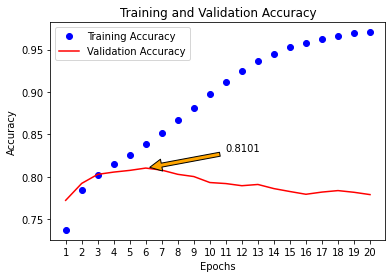

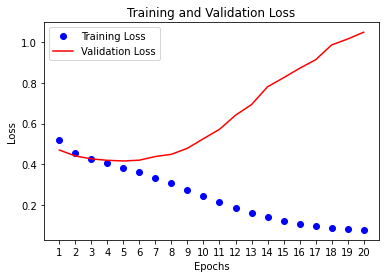

In [ ]:
history = model_clean_data.history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
y_arrow = max(val_acc)
x_arrow = val_acc.index(y_arrow) + 1
plt.annotate(str(y_arrow)[:6],
             (x_arrow, y_arrow),
             xytext=(x_arrow + 5, y_arrow + .02),
             arrowprops=dict(facecolor='orange', shrink=0.05))
plt.xticks(epochs)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.show()

Wow, now that's a considerable performance gain! The model managed to reach an impressive **81.1%** validation accuracy on the 5th epoch!

This goes to prove the following: **The model is as good as the data**.

Nonetheless, the over-fitting problem is still persistent in the model. This could be further reduced by introducing a more aggressive regularization and training the model for a much bigger number of epochs, and by also training the model on a bigger, more diverse, cleaner data.

## 5.6. Predicting on Custom Data <a class="anchor" id="head-5-6"></a>

Now let’s have some fun testing our **new and all-powerful** model on some custom data!

This model will return values between 0 and 1, representing it’s confidence on whether a tweet holds a negative or a positive sentiment. The closer the value is to 0, the more confident the model is that this tweet is negative. The closer the value is to 1, the more confident the model is that this tweet is negative.


In [ ]:
def sentence_to_indices(sentence_words, max_len):
    X = np.zeros((max_len))
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
        X[j] = index
    return X

def predict_custom_tweet_sentiment(custom_tweet):
    # Convert the tweet such that it can be fed to the model
    x_input = sentence_to_indices(remove_noise(tk.tokenize(custom_tweet)), max_len)
    
    # Retrun the model's prediction
    return model_clean_data.predict(np.array([x_input])).item()

In [ ]:
predict_custom_tweet_sentiment("I'm happy you're here!")

0.9996429681777954

In [ ]:
predict_custom_tweet_sentiment("I'm not happy you're here!")

3.0138342481222935e-05

Woohoo, our model can now easily understand the relationship between words! It managed to identify that adding a *not* before a *happy*, would completely **switch** its meaning!

In [ ]:
predict_custom_tweet_sentiment("I disliked his attitude...")

0.06084639951586723

In [ ]:
predict_custom_tweet_sentiment("I'm infatuated with you")

0.9458361864089966

In [ ]:
(negative_words + positive_words).count('love')

17634

In [ ]:
(negative_words + positive_words).count('infatuated')

0

Our model is even capable of correctly predicting the sentiment of words **it never encountered** during training!

The word *Infatuated* never appeared neither in the positive nor negative tweets. However, given that it’s strongly related to the word *love* (a very frequently appearing word in our data), and thanks to the use of **word embeddings**, the model was capable of assigning a positive sentiment to this word!

## 5.7. Inspecting Wrongly Predicted Data <a class="anchor" id="head-5-7"></a>

Let's take a look at some of the wrongly classified data from the model.

In [ ]:
def i_to_sentence(I):
    sentence = ""
    for i in I:
        if i:
            sentence += index_to_word[int(i)] + " "
        else:
            break
    return sentence

In [ ]:
C = 0

pred = model_clean_data.predict(X_test)

for i in range(len(X_test)):
    final_pred = 1 if pred[i] > 0.5 else 0
    
    if(final_pred != Y_test[i]):
        print('Expected sentiment: ' + str(int(Y_test[i])) + '. Input: ' + i_to_sentence(X_test[i]))
        C += 1
        
    if C > 100:
        break

Expected sentiment: 1. Input: populating an online shop with home automation goodies 
Expected sentiment: 0. Input: you sure i can if you want to because i want to and lol fish fish it actually really healthy silly its good for you so eat 
Expected sentiment: 0. Input: i can understand ... sorry for making you talk about it cherish the positive memories 
Expected sentiment: 0. Input: unk you get tht from 
Expected sentiment: 1. Input: turma da unk ¿ unk ï ¿ ½ show 
Expected sentiment: 1. Input: my computer is unk ... but having loads of fun with bailey this weekend 
Expected sentiment: 0. Input: unk at the cubs game while i stay home to do homework and look for my cabaret costume anyone have some 20s apparel i could borrow 
Expected sentiment: 1. Input: just waking up i have final exams this week not excited to take them but excited to be done 
Expected sentiment: 0. Input: cool thanks shd check apple ones but i still unk find a maemo unk player with an equalizer gonna check xms now 
E

Skimming through the above output, we can "understand" why the model wouldn't properly classify several examples. Some examples seem wrongly labeled in the first place, whereas some other examples are really hard to classify without further context.

So all in all, I would say that our current model is relatively robust in classifying the sentiment in a given sentence!

# 6. Bonus Section <a class="anchor" id="head-6"></a>

As someone who's extremely passionate about data, I couldn't help but try and explore further correlations in the data. And I'm excited to share with you a couple of my findings!

Even though this project is specifically focused on NLP, the following is completely unrelated to NLP.

So, while looking at the data I thought to myself: *could the tweet date have any correlation(s) with the tweet sentiment?*.

Let's find out!

In [ ]:
# Taking only the label and the date in order to work on them
df_date = df_raw.copy()[['label', 'date']]
df_date.head()

,label,date
0,0,Mon Apr 06 22:19:45 PDT 2009
1,0,Mon Apr 06 22:19:49 PDT 2009
2,0,Mon Apr 06 22:19:53 PDT 2009
3,0,Mon Apr 06 22:19:57 PDT 2009
4,0,Mon Apr 06 22:19:57 PDT 2009


In [ ]:
# Adding a field to our dataframe, hour, containing the hour in which the tweet was published
df_date['hour'] = df_date.date.apply(lambda x: x[11:13]).astype('int32')
df_date.head()

,label,date,hour
0,0,Mon Apr 06 22:19:45 PDT 2009,22
1,0,Mon Apr 06 22:19:49 PDT 2009,22
2,0,Mon Apr 06 22:19:53 PDT 2009,22
3,0,Mon Apr 06 22:19:57 PDT 2009,22
4,0,Mon Apr 06 22:19:57 PDT 2009,22


In [ ]:
# Adding a field to our dataframe, dow, containing the day of week in which the tweet was published
df_date['dow'] = df_date.date.apply(lambda x: x[:3]).astype('str')
df_date.head()

,label,date,hour,dow
0,0,Mon Apr 06 22:19:45 PDT 2009,22,Mon
1,0,Mon Apr 06 22:19:49 PDT 2009,22,Mon
2,0,Mon Apr 06 22:19:53 PDT 2009,22,Mon
3,0,Mon Apr 06 22:19:57 PDT 2009,22,Mon
4,0,Mon Apr 06 22:19:57 PDT 2009,22,Mon


In [ ]:
# Building a pivot table that breaks-down the number of positive and negative tweets in each hour of the day
temporal_hour = pd.pivot_table(df_date, index='label', columns='hour', aggfunc='size', fill_value=0)
temporal_hour

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
label,,,,,,,,,,,,,,,,,,,,,
0,35582,30581,30171,31717,34946,37774,40076,42208,40166,36511,...,27077,28531,31594,29316,29422,31193,30102,36007,39018,39506
4,45283,44687,43820,42536,42049,40849,40776,41446,36121,30767,...,23303,22112,24126,22527,24063,26529,26957,32957,39310,45244


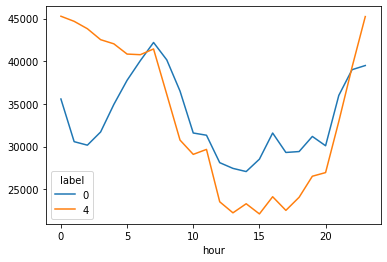

In [ ]:
# Plotting our results
temporal_hour.transpose().plot()

It's super interesting to see that it turns out that there's a relationship between the time of the tweet (in terms of hours of day) and whether this tweet has a positive or negative sentiment!

In fact, from this graph I concluded two things:

* There's a specific interval of time in which positive tweets outnumber the negative tweets, and another interval in which the opposite occurs.
* When the total number of tweets is relatively high, the majority of the tweets tend to have a positive sentiment. This *could* also mean that positive tweets come in big batches, maybe relating to a similar subject (soccer game, movie release, etc), whereas negative tweets are more sparsely distributed.

Also, you might find it weird that the biggest number of tweets occurs between 12AM and 7AM, however keep in mind that this is the raw date we've read from the data, and could quite possibly need to be converted to another timezone. As it stands, I cannot directly draw a conclusion as to which specific time frame favors positive or negative tweets, as I'm not entirely sure how to convert the given dates to the appropriate timezone of the collected data. So just look at the shape of the graph, without necesseraly pinpointing the hour coordinates. I.e., the graph could be shifted in any (horizontal) direction and still hold the same meaning.

In [ ]:
# Transforming the above pilot table such that it now contains the percentage
# of negative/positive tweets in each hour of the day
temporal_hour = temporal_hour.iloc[:, :].apply(lambda x: x / x.sum())
temporal_hour

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
label,,,,,,,,,,,,,,,,,,,,,
0,0.440017,0.406295,0.407766,0.427148,0.453874,0.480445,0.495671,0.504554,0.526512,0.542689,...,0.537455,0.563375,0.567014,0.565477,0.550098,0.540401,0.527559,0.522113,0.498136,0.466147
4,0.559983,0.593705,0.592234,0.572852,0.546126,0.519555,0.504329,0.495446,0.473488,0.457311,...,0.462545,0.436625,0.432986,0.434523,0.449902,0.459599,0.472441,0.477887,0.501864,0.533853


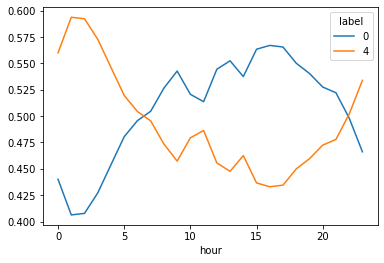

In [ ]:
# Plotting our results
temporal_hour.transpose().plot()

This almost looks like it's oscillating!

In [ ]:
# Building a pivot table that breaks-down the number of positive and negative tweets in each day of the week
temporal_dow = pd.pivot_table(df_date, index='label', columns='dow', aggfunc='size', fill_value=0)
temporal_dow

dow,Fri,Mon,Sat,Sun,Thu,Tue,Wed
label,,,,,,,
0,114600,132539,157734,145471,80132,101051,68473
4,110994,177666,173221,199084,25903,84799,28333


In [ ]:
# Re-ordering our table
temporal_dow = temporal_dow[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]
temporal_dow

dow,Mon,Tue,Wed,Thu,Fri,Sat,Sun
label,,,,,,,
0,132539,101051,68473,80132,114600,157734,145471
4,177666,84799,28333,25903,110994,173221,199084


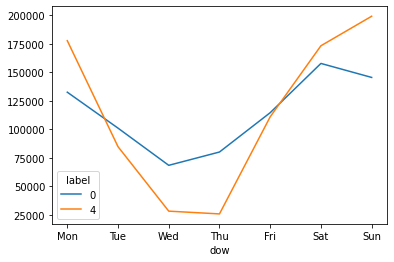

In [ ]:
# Plotting our results
temporal_dow.transpose().plot()

It's always cool to have real world data reflect what one would guess as: *yeah, it should look like this*.

Here also, two insights can be drawn from the graph:

* People tend to tweet more positively during the weekends, when they relax and attend events, whereas negative tweets are dominant during the rest of the week, showcasing people's dissatisfaction with their work.
* A much bigger number of tweets is circulated during the weekend, relative to the rest of the week.

This actually slightly reinforces our prior hypotheses that *positive tweets come in big batches, maybe relating to a similar subject*, as such events usually occur on the weekends.

Also, keep in mind that this graph could also be shifted either to the left or to the right, as the tweets appearing to have a date *Monday 1AM* for example could end up being on *Sunday 8PM*, or vise versa.

In [ ]:
# Transforming the above pilot table such that it now contains the percentage
# of negative/positive tweets in each day of the week
temporal_dow = temporal_dow.iloc[:, :].apply(lambda x: x / x.sum())
temporal_dow

dow,Mon,Tue,Wed,Thu,Fri,Sat,Sun
label,,,,,,,
0,0.427263,0.543723,0.707322,0.755713,0.507992,0.476603,0.4222
4,0.572737,0.456277,0.292678,0.244287,0.492008,0.523397,0.5778


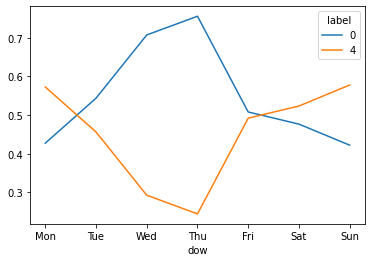

In [ ]:
temporal_dow.transpose().plot()

That's it for the small detour! It's really fun to try and squeeze out every ounce of information from the data! And who knows, maybe we can combine this information with our current model, as to give more weights to a certain class depending on the date of the tweet!

# 7. Extra Tip: Pickling ! <a class="anchor" id="head-7"></a>

*“Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream is converted back into an object hierarchy.*<br>
This means that we can save on our drive any object in python! In our case, the "*final_data*" list took 11 minutes to compute! So, if were to come back to our code and decide to add a visualization or extra code, and instead of re-processing this list, we can *pickle* it on our drive and later load it back from our drive in less than a second!

In [ ]:
import pickle

In [ ]:
# Saving a python object to disk
pickle.dump(classifier, open("classifier.p", "wb"))

In [ ]:
# Loading a python object from disk
classifier = pickle.load(open("classifier.p", "rb"))

# 8. Further Work <a class="anchor" id="head-8"></a>

* Further data cleaning and relabelling. As the data origin is from twitter, it is expected to contain a wide range of not "official" english words, so data cleaning is crucial in such a scenario. Furthermore, as the data labelling has been done automatically based on the reactions of the tweet, this labelling is by no means perfect and a human re-labelling of the whole data would certainly be beneficial.
* Introduce a neutral class, transforming the problem to a multi-class classification problem.
* Try out several other word embeddings or model architectures.
* Augment the data by diversifying it in order to make the model more robust, especially against sarcasm.